Figure 1 from Louis Moresi's SIAM News publication in 2015: http://www.moresi.info/posts/Computational-Challenges-SIAM-NEWS/


_The surface of the Earth is continually moving in response to convection currents in the underlying mantle. A map of the surface velocities shows the motions are organised into a strikingly simple pattern of surface "plates" that are almost rigid bodies. The surface strain rate - coloured contours - is concentrated at the plate boundaries. On closer inspection, there are many regions within the continental crust where the motions are diffuse, not at all plate-like. The arrows are colored by their angle to North as a means of distinguishing the different plates. The scale is such that the longest vector represents 10cm/yr._

The image is composed of a background grayscale topography / bathymetry map, plate motion vectors (in a Europe-fixed frame) and contours of the observed strain rate second invariant. These data are available after running [Notebook 0](/notebooks/Mapping/0%20-%20Preliminaries.ipynb#) to download / install everything. 

In [3]:
%%sh

# This will run notebook 0 to download all the required data for this example. 

runipy '0 - Preliminaries.ipynb' --quiet 

sh: line 4: runipy: command not found


In [1]:
%pylab inline

from osgeo import gdal
from osgeo import gdal_array

import cartopy.crs as ccrs
import matplotlib.pyplot as plt

import cartopy.feature as cfeature

from scipy.io import netcdf

Populating the interactive namespace from numpy and matplotlib


In [2]:

# The colormap routine creates enormous arrays in intermediary calculations. This is
# a way to avoid memory errors: process to RGB (int8) in advance

def apply_colormap_to_image(rawimage, colormap, norm):

    greyimage = norm(rawimage)
    rgbimage = np.empty((greyimage.shape[0], greyimage.shape[1] , 4), dtype=uint8)

    for i in range(0, greyimage.shape[0]):
        rgbimage[i,:,:] = colormap(greyimage[i,:]) * 256
                
    rgbimage2 = rgbimage[:,:,0:3]        
    
    return rgbimage2
    

In [3]:
base_projection     = ccrs.PlateCarree() 
global_extent     = [-180.0, 180.0, -90.0, 90.0]

strainrate_extent=[-180,180,-68,80]
strainrate = numpy.loadtxt("../../Data/Resources/sec_invariant_strain_0.2.dat")
strainrate_data = strainrate.reshape(741,1800,3)  # I had to look at the data to work this out !
# strainrate_img  = strainrate_data[:,:,2] # Not actually used here !

In [4]:
# Note: we need to manage the memory here since the Docker version has more 
# memory constraints than the native installation. Be sure to del() unused arrays/images

# Etopo Height field as geotiff

etopoH = gdal.Open("../../Data/Resources/ETOPO1_Ice_c_geotiff.tif") 
etopoH_img = etopoH.ReadAsArray()[::2,::2].astype(numpy.float16)
del(etopoH)

colormap = plt.get_cmap('Greys')
norm = matplotlib.colors.Normalize(vmin=-10000, vmax=5000)
etopoH_img_grey = apply_colormap_to_image(etopoH_img, colormap, norm)

# These are alternative images 

# etopo1       = gdal.Open("Resources/color_etopo1_ice_low.tif")
# etopo_img    = etopo1.ReadAsArray().transpose(1,2,0)
# del(etopo1)

# global_shrelief = gdal.Open("Resources/etopo1_grayscale_hillshade.tif")
# global_shrelief_img = global_shrelief.ReadAsArray()[::2,::2].astype(numpy.float16)
# del(global_shrelief)
# print "global_shrelief_img - ", global_shrelief_img.shape


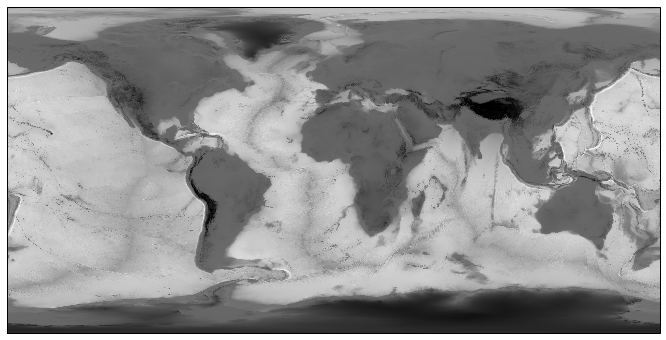

In [5]:
# How does that look in the Native Projection ?

fig = plt.figure(figsize=(12, 6), facecolor="none")
ax = plt.axes(projection=base_projection)
ax.imshow(etopoH_img_grey[::1,::1], transform=ccrs.PlateCarree(), origin="upper", 
          alpha=1.0, extent=global_extent,  zorder=0)


In [6]:
# Some features we need for the map 


coastline = cfeature.NaturalEarthFeature('physical', 'coastline', '50m',
                           edgecolor=(0.0,0.0,0.0),
                           facecolor="none")

rivers = cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', '50m',
                                        edgecolor='Blue', facecolor="none")

lakes = cfeature.NaturalEarthFeature('physical', 'lakes', '50m',
                                        edgecolor="blue", facecolor="blue")

ocean = cfeature.NaturalEarthFeature('physical', 'ocean', '50m',
                           edgecolor="green",
                           facecolor="blue")

graticules_5 = cfeature.NaturalEarthFeature('physical', 'graticules_5', '10m',
                           edgecolor="black", facecolor=None)


In [7]:
## Reading the velocity vector data from the EU-fixed dataset

rootgrp = netcdf.netcdf_file(filename="../../Data/Reference/velocity_NNR.nc", version=2)

ve = rootgrp.variables["ve"]
vn = rootgrp.variables["vn"]

lonv = rootgrp.variables["lon"]
latv = rootgrp.variables["lat"]

lons = lonv[::5]
lats = latv[::5]
llX, llY = np.meshgrid(lons,lats)

#llX = llX.reshape(-1)
#llY = llY.reshape(-1)

Veast = (np.array(ve[::5,::5]).T)
Vnorth = (np.array(vn[::5,::5]).T)

Vorientation = np.arctan2(Vnorth,Veast)

/usr/local/lib/python3.7/site-packages/matplotlib/contour.py:1000: UserWarning: The following kwargs were not used by contour: 'linestyle'
  s)


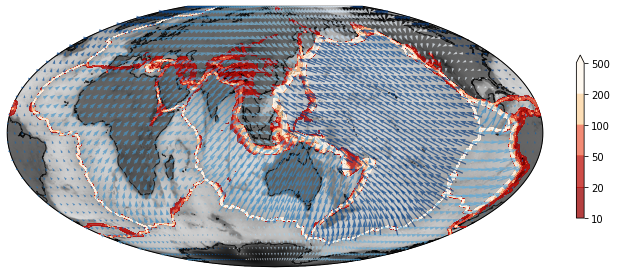

In [8]:
# I used Robinson in the article but it keeps crashing for me now !

#projection = ccrs.PlateCarree() # For debugging, this one is quick
#projection = ccrs.Orthographic(central_longitude=-150.0, central_latitude=60.0, globe=None)
#projection = ccrs.Orthographic(central_longitude=120.0, central_latitude=5.0, globe=None)
projection = ccrs.Mollweide(central_longitude=120)
#projection = ccrs.Robinson(central_longitude=120) # This is the one in the paper

fig = plt.figure(figsize=(12, 6), facecolor="none")

ax = plt.axes(projection=projection)

# Still too large for the memory 
ax.imshow(etopoH_img_grey[::4,::4,:], transform=ccrs.PlateCarree(), origin="upper", 
          alpha=1.0, extent=global_extent, interpolation="spline16", zorder=0)


mappable2 = ax.contourf(strainrate_data[:,:,0], strainrate_data[:,:,1], strainrate_data[:,:,2], 
         levels=[10, 20, 50, 100, 200, 500], linestyle=None, vmin=1.0, vmax=200,
         transform=base_projection,  cmap=cm.OrRd_r, alpha=0.75, 
         extent=strainrate_extent, extend="max", zorder=12)

plt.colorbar(mappable=mappable2, shrink=0.5)


mappable1 = ax.quiver(llX, llY, Veast, Vnorth, Vorientation, scale=2000, transform=ccrs.PlateCarree(),
        cmap=cm.Blues, alpha=0.7, zorder=13, pivot="mid")


ax.add_feature(coastline, linewidth=1.0,  edgecolor="#000000", zorder=2, alpha=0.75)
# ax.add_feature(rivers,    linewidth=1,    edgecolor="Blue", zorder=2)
# ax.add_feature(lakes,     linewidth=1,    edgecolor="Blue", zorder=3, alpha=0.25)
# ax.add_feature(graticules_5, linewidth=0.25, edgecolor="black", linestyle=":", zorder=1, alpha=0.75)

In [9]:
#fig.savefig("PlateMotionsPlateCarree.png", dpi=300) 
#fig.savefig("PlateMotionsRobinson.png", dpi=500)
fig.savefig("PlateMotionsMollweide.png", dpi=500)

etopoH_img -  (5400, 10800)
globalrelief_img -  (5400, 10800, 3)


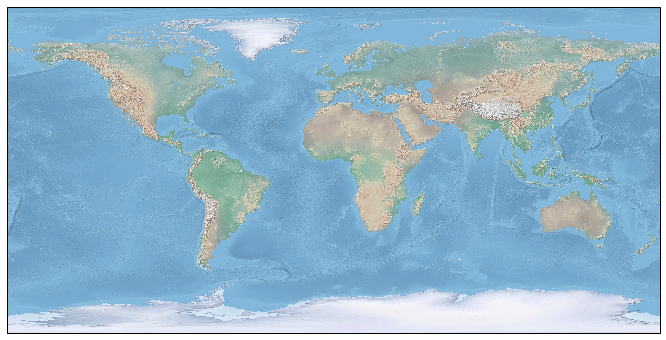

In [11]:
## This was an alternative to the background image which I thought might look good:

globalrelief      = gdal.Open("../../Data/Resources/HYP_50M_SR_W/HYP_50M_SR_W.tif")
globalrelief_img  = globalrelief.ReadAsArray().transpose(1,2,0)
del(globalrelief)

globalbathym      = gdal.Open("../../Data/Resources/OB_50M/OB_50M.tif")
globalbathym_img  = globalbathym.ReadAsArray().transpose(1,2,0)
del(globalbathym)

print ("etopoH_img - ", etopoH_img.shape)
print ("globalrelief_img - ", globalrelief_img.shape)

blended_img = np.empty_like(globalrelief_img)
blended_img[...,0] = np.where( etopoH_img < 0.0, globalbathym_img[...,0], globalrelief_img[...,0] )
blended_img[...,1] = np.where( etopoH_img < 0.0, globalbathym_img[...,1], globalrelief_img[...,1] )
blended_img[...,2] = np.where( etopoH_img < 0.0, globalbathym_img[...,2], globalrelief_img[...,2] )

del(globalbathym_img)
del(globalrelief_img)

fig = plt.figure(figsize=(12, 6), facecolor="none")
ax = plt.axes(projection=base_projection)
ax.imshow(blended_img[::1,::1], transform=ccrs.PlateCarree(), origin="upper", 
          alpha=1.0, extent=global_extent,  zorder=0)



In [14]:
# Do this if the relief / bathym sizes don't match the etopo data (to make the blended image)
# The datasets we downloaded can be manipulated trivially without the need for this and I have
# commented it all out so you can run all cells without reprocessing the data files. 


"""
import scipy.ndimage
import scipy.misc


etopoH = gdal.Open("Resources/ETOPO1_Ice_g_geotiff.tif")
etopoH_img = etopoH.ReadAsArray()

print 

etopoH_transform = etopoH.GetGeoTransform()
globalrelief_transform = globalrelief.GetGeoTransform()

# Resize to match globalrelief ... this resize is int only ??

globaletopoH = scipy.misc.imresize(etopoH_img, globalrelief_img.shape, mode='F')

## How to turn this array back into the appropriate geotiff

from osgeo import gdal
from osgeo import osr

# data exists in 'ary' with values range 0 - 255
# Uncomment the next line if ary[0][0] is upper-left corner
#ary = numpy.flipup(ary)

Ny, Nx = globaletopoH.shape
driver = gdal.GetDriverByName("GTiff")
# Final argument is optional but will produce much smaller output file
ds = driver.Create('output.tif', Nx, Ny, 1, gdal.GDT_Float64, ['COMPRESS=LZW'])

# this assumes the projection is Geographic lat/lon WGS 84
srs = osr.SpatialReference()
srs.ImportFromEPSG(4326)
ds.SetProjection(srs.ExportToWkt())

ds.SetGeoTransform( globalrelief_transform  ) # define GeoTransform tuple
ds.GetRasterBand(1).WriteArray(globaletopoH)
ds = None
"""

'\nimport scipy.ndimage\nimport scipy.misc\n\n\netopoH = gdal.Open("Resources/ETOPO1_Ice_g_geotiff.tif")\netopoH_img = etopoH.ReadAsArray()\n\nprint \n\netopoH_transform = etopoH.GetGeoTransform()\nglobalrelief_transform = globalrelief.GetGeoTransform()\n\n# Resize to match globalrelief ... this resize is int only ??\n\nglobaletopoH = scipy.misc.imresize(etopoH_img, globalrelief_img.shape, mode=\'F\')\n\n## How to turn this array back into the appropriate geotiff\n\nfrom osgeo import gdal\nfrom osgeo import osr\n\n# data exists in \'ary\' with values range 0 - 255\n# Uncomment the next line if ary[0][0] is upper-left corner\n#ary = numpy.flipup(ary)\n\nNy, Nx = globaletopoH.shape\ndriver = gdal.GetDriverByName("GTiff")\n# Final argument is optional but will produce much smaller output file\nds = driver.Create(\'output.tif\', Nx, Ny, 1, gdal.GDT_Float64, [\'COMPRESS=LZW\'])\n\n# this assumes the projection is Geographic lat/lon WGS 84\nsrs = osr.SpatialReference()\nsrs.ImportFromEPSG(43